# Exercise 4

## 1. Constructing the matrix X

In the first step we are going to implemnt the function X = construct_X(M, alphas, Np = None) naively without any sparse matrix optimizations

In [5]:
import numpy as np
from scipy.sparse import coo_matrix, csc_matrix
import matplotlib.pyplot as plt

In [2]:

def construct_X(M, alphas, Np = None):
    """
    Construct a matrix X which describes the setup of a simplyfied
    CT scanner after the formular X*beta = y, with beta being a flattend 
    tomograph and y being a flattened sinogram.
    
    M = Disired tomograph size D = M x M
    alpha = list of measurement angles
    Np = optional sensor resolution
    """

    D = M * M
    N_o = len(alphas)

    # If no resolution is givin a value of sqrt(2)*M is set
    if Np == None:
        Np = int(np.ceil(np.sqrt(2) * M))

    N = Np*N_o

    X = np.zeros((N, D))
    
    for i_o, alpha in enumerate(alphas):
        # Rotate coordinate
        angle = np.deg2rad(alpha)
        
        for j_a in range(M):
            for j_b in range(M):
                j = j_a + M * j_b

                # Calculate the coordinate with the center being (0,0)
                x = j_a - (M - 1) / 2
                y = j_b - (M - 1) / 2

                # Rotate pixel coordinates as sensor array angle 
                x_rot =  x * np.cos(angle) - y * np.sin(angle)

                # Project the tomogram's pixel coordinates on sensor array
                sensor_location = (x_rot + (Np - 1) / 2)
                ray_intensity = sensor_location - np.floor(sensor_location)
                
                # Determine the sensor indices influenced by the ray
                sensor_index1 = int(np.floor(sensor_location))
                sensor_index2 = int(np.ceil(sensor_location))
                
                # Calculate the weights based on the distance from the center of the bins
                if sensor_index1 >= 0 and sensor_index1 < Np:
                    X[sensor_index1 + Np * i_o, j] += 1 - ray_intensity
                if sensor_index2 >= 0 and sensor_index2 < Np:    
                    X[sensor_index2 + Np * i_o, j] += ray_intensity

    return X


In the next step we are going to write the function more efficiently by vectorizing it and using sparse matrices

In [22]:

def construct_X(M, alphas, Np = None):
    """
    Construct a matrix X which describes the setup of a simplyfied
    CT scanner after the formular X*beta = y, with beta being a flattend 
    tomograph and y being a flattened sinogram.
    
    M = Disired tomograph size D = M x M
    alpha = list of measurement angles
    Np = optional sensor resolution
    """

    D = M * M
    N_o = len(alphas)

    # If no resolution is givin a value of sqrt(2)*M is set
    if Np == None:
        Np = int(np.ceil(np.sqrt(2) * M))
    
    N = Np*N_o

    i_indices = []
    j_indices = []
    weights = []
    
    # Rotate coordinate
    alphas = np.deg2rad(alphas)

    # Create coordinates of the tomogram's pixel centers       
    j_a, j_b = np.meshgrid(range(M), range(M))
    j_a = j_a.flatten()
    j_b = j_b.flatten()
    j = j_a + M * j_b


    # Calculate the y coordinate with the center being (0,0)
    x = j_a - (M - 1) * 0.5
    y = j_b - (M - 1) * 0.5

    for i_o, alpha in enumerate(alphas):

        # Rotate pixel coordinates as sensor array angle
        x_rot =  x * np.cos(alpha) - y * np.sin(alpha)

        # Project the tomogram's pixel coordinates on sensor array
        sensor_location = (x_rot + (Np - 1) * 0.5)
        ray_intensity = sensor_location - np.floor(sensor_location)
                
        # Determine the sensor indices influenced by the ray
        sensor_index1 = np.floor(sensor_location).astype(int)
        sensor_index2 = np.ceil(sensor_location).astype(int)

        # Test if indices are valid
        valid_indices1 = np.logical_and(sensor_index1 >= 0, sensor_index1 < Np)
        valid_indices2 = np.logical_and(sensor_index2 >= 0, sensor_index2 < Np)
                
        i_indices.extend(np.where(valid_indices1, sensor_index1 + Np * i_o, 0))
        j_indices.extend(np.where(valid_indices1, j.flatten(), 0))
        weights.extend(np.where(valid_indices1, 1 - ray_intensity, 0))

        i_indices.extend(np.where(valid_indices2, sensor_index2 + Np * i_o, 0))
        j_indices.extend(np.where(valid_indices2, j.flatten(), 0))
        weights.extend(np.where(valid_indices2, ray_intensity, 0))
                    
    
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)

    return X


Lets check if the matix construction works

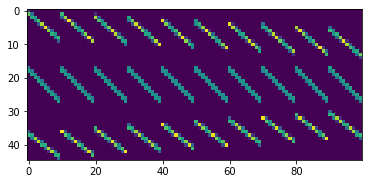

In [23]:
X=construct_X(10, [-33, 1, 42])
# convert X to dense matrix for visualization
X = X.toarray()
plt.imshow(X)


Now we compare it to the given example

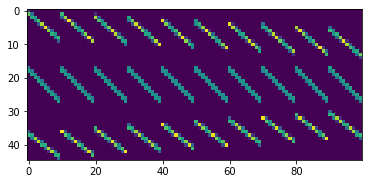

In [24]:
X_ref = np.load('hs_tomography/X_example.npy')
plt.imshow(X_ref)

We see, the algorithm works and the two solutions are equal!

## 2. Recovering the image

## 3. Minimizing the radiation dose